In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models



# # Define stock symbols with their names
# stock_symbols = {
#     "D05.SI": "DBS Group",
#     "O39.SI": "OCBC Bank",
#     "U11.SI": "UOB Bank",
#     "Z74.SI": "SingTel",
#     "F34.SI": "Wilmar International",
#     "Q0F.SI": "IHH Healthcare",
#     "C6L.SI": "Singapore Airlines",
#     "S63.SI": "ST Engineering",
#     "J36.SI": "Jardine Matheson",
#     "S68.SI": "SGX",
#     "C38U.SI": "CapitaLand Integrated Commercial Trust",
#     "Y92.SI": "Thai Beverage",
#     "H78.SI": "Hongkong Land",
#     "9CI.SI": "CapitaLand Investment",
#     "G07.SI": "Great Eastern",
#     "BN4.SI": "Keppel Corp",
#     "BS6.SI": "Yangzijiang Shipbuilding",
#     "A17U.SI": "Ascendas REIT",
#     "C07.SI": "Jardine C&C",
#     "U96.SI": "Sembcorp Industries",
#     "G13.SI": "Genting Singapore",
#     "5E2.SI": "Seatrium",
#     "N2IU.SI": "Mapletree Pan Asia Commercial Trust",
#     "M44U.SI": "Mapletree Logistics Trust",
#     "ME8U.SI": "Mapletree Industrial Trust",
#     "S58.SI": "SATS",
#     "AJBU.SI": "Keppel DC REIT"
# }


# Define stock symbols with their names
stock_symbols = {
    "U11.SI": "UOB Bank",
    "Z74.SI": "SingTel",
    "F34.SI": "Wilmar International",
    "Q0F.SI": "IHH Healthcare",
    "S63.SI": "ST Engineering",
    "J36.SI": "Jardine Matheson",
    "S68.SI": "SGX",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "H78.SI": "Hongkong Land",
    "9CI.SI": "CapitaLand Investment",
    "BN4.SI": "Keppel Corp",
    "A17U.SI": "Ascendas REIT",
    "C07.SI": "Jardine C&C",
    "U96.SI": "Sembcorp Industries",
    "G13.SI": "Genting Singapore",
    "5E2.SI": "Seatrium",
    "N2IU.SI": "Mapletree Pan Asia Commercial Trust",
    "ME8U.SI": "Mapletree Industrial Trust",
    "S58.SI": "SATS",
    "AJBU.SI": "Keppel DC REIT"
}

# Fetch fundamentals with validation
def fetch_fundamentals(symbols):
    fundamentals = {}
    for symbol in symbols:
        try:
            stock = yf.Ticker(symbol)
            info = stock.info
            pe = info.get("trailingPE")
            risk = info.get("beta")
            growth = info.get("earningsGrowth")
            health = info.get("returnOnEquity")
            if None in (pe, risk, growth, health):
                continue
            fundamentals[symbol] = {
                "PE": pe,
                "Risk": risk,
                "Growth": growth,
                "Health": health
            }
        except Exception as e:
            print(f"Skipping {symbol}: {e}")
            continue
    return fundamentals

fundamentals = fetch_fundamentals(stock_symbols.keys())

# Calculate peak/trough speed
def get_peak_trough_speed(symbol):
    try:
        stock = yf.Ticker(symbol)
        hist = stock.history(period="10y")
        close = hist["Close"]
        peaks = close[close == close.rolling(15, center=True).max()].dropna()
        troughs = close[close == close.rolling(15, center=True).min()].dropna()
        if len(peaks) > 1 and len(troughs) > 1:
            peak_speed = np.mean(np.diff(peaks.index.to_numpy()).astype('timedelta64[D]').astype(int))
            trough_speed = np.mean(np.diff(troughs.index.to_numpy()).astype('timedelta64[D]').astype(int))
        else:
            peak_speed, trough_speed = np.inf, np.inf
        return peak_speed, trough_speed
    except Exception as e:
        print(f"Error processing {symbol} for peak/trough: {e}")
        return np.inf, np.inf

# Build RL model to generate weights
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(2,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='relu')
])
model.compile(optimizer='adam', loss='mse')

# Prepare dataset
data_rows = []
for symbol in fundamentals:
    peak, trough = get_peak_trough_speed(symbol)
    if np.isinf(peak) or np.isinf(trough):
        continue
    inputs = np.array([[peak, trough]])
    weight = model.predict(inputs, verbose=0)[0][0]
    data_rows.append({
        "Symbol": symbol,
        "Name": stock_symbols.get(symbol, symbol),
        "PE": fundamentals[symbol]["PE"],
        "Risk": fundamentals[symbol]["Risk"],
        "Growth": fundamentals[symbol]["Growth"],
        "Health": fundamentals[symbol]["Health"],
        "PeakSpeed": peak,
        "TroughSpeed": trough,
        "RL_Weight": weight
    })

# Create DataFrame and pick top 6
df = pd.DataFrame(data_rows)

if not df.empty and "Growth" in df.columns:
    df = df[df["Growth"].notna() & (df["Growth"] > 0)]
    df = df.sort_values(by="RL_Weight", ascending=False).head(6)
# Download 3-year historical returns for correlation filtering
def get_returns(symbol):
    try:
        stock = yf.Ticker(symbol)
        hist = stock.history(period="3y")
        returns = hist["Close"].pct_change().dropna()
        return returns
    except Exception as e:
        print(f"Error fetching returns for {symbol}: {e}")
        return None

# Build return series DataFrame for correlation analysis
return_data = {}
for symbol in df["Symbol"]:
    ret = get_returns(symbol)
    if ret is not None:
        return_data[symbol] = ret

returns_df = pd.DataFrame(return_data).dropna(axis=1)

# Select stocks with correlation < 0.7
selected_symbols = []
for symbol in df["Symbol"]:
    if symbol not in returns_df.columns:
        continue
    if not selected_symbols:
        selected_symbols.append(symbol)
    else:
        correlations = returns_df[selected_symbols].corrwith(returns_df[symbol])
        if all(abs(correlations) < 0.7):
            selected_symbols.append(symbol)
    if len(selected_symbols) == 6:
        break

# Final filtered dataframe
df_filtered = df[df["Symbol"].isin(selected_symbols)]

print("\nSelected 6 Diverse & Low-Correlation Stocks:")
print(df_filtered)

# Save filtered results
df_filtered.to_csv("graphselect_top6_singapore_stocks.csv", index=False)
print("\nSaved to 'selected_top6_singapore_stocks.csv'")


2025-03-27 02:00:53.817651: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 02:00:54.034367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-27 02:00:54.034404: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-27 02:00:59.748637: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-27 02:00:59.748680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (priya-Vivob


Selected 6 Diverse & Low-Correlation Stocks:
     Symbol                                    Name         PE   Risk  Growth  \
0    U11.SI                                UOB Bank  10.692090  0.699   0.110   
4    S68.SI                                     SGX  21.557377  0.117   0.238   
3    S63.SI                          ST Engineering  30.318182  0.529   0.195   
5   C38U.SI  CapitaLand Integrated Commercial Trust  15.071427  0.750   0.134   
10  AJBU.SI                          Keppel DC REIT  12.882353  0.588   3.730   
2    Q0F.SI                          IHH Healthcare  23.111109  0.190   0.006   

     Health  PeakSpeed  TroughSpeed  RL_Weight  
0   0.12567  33.073394    31.342105   5.573005  
4   0.35105  26.529412    27.507576   4.440585  
3   0.25572  23.000000    23.456954   3.854732  
5   0.06253  22.214724    19.769231   3.759384  
10  0.10863  17.735294    18.120000   2.971975  
2   0.09543  14.345238    13.733840   2.415478  

Saved to 'selected_top6_singapore_stocks.c

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


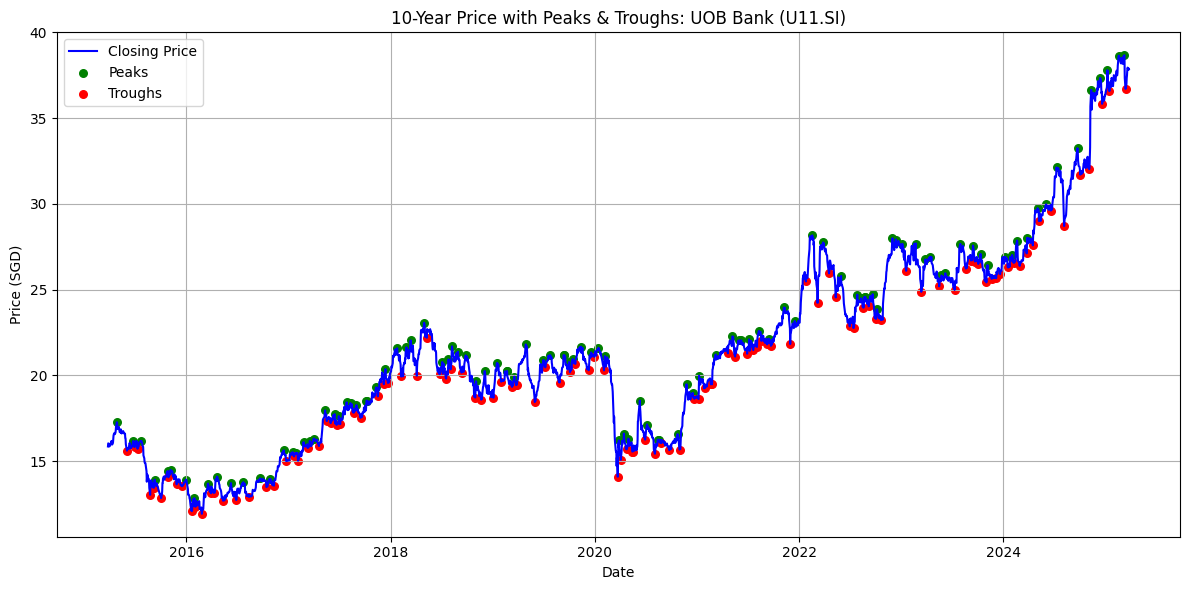

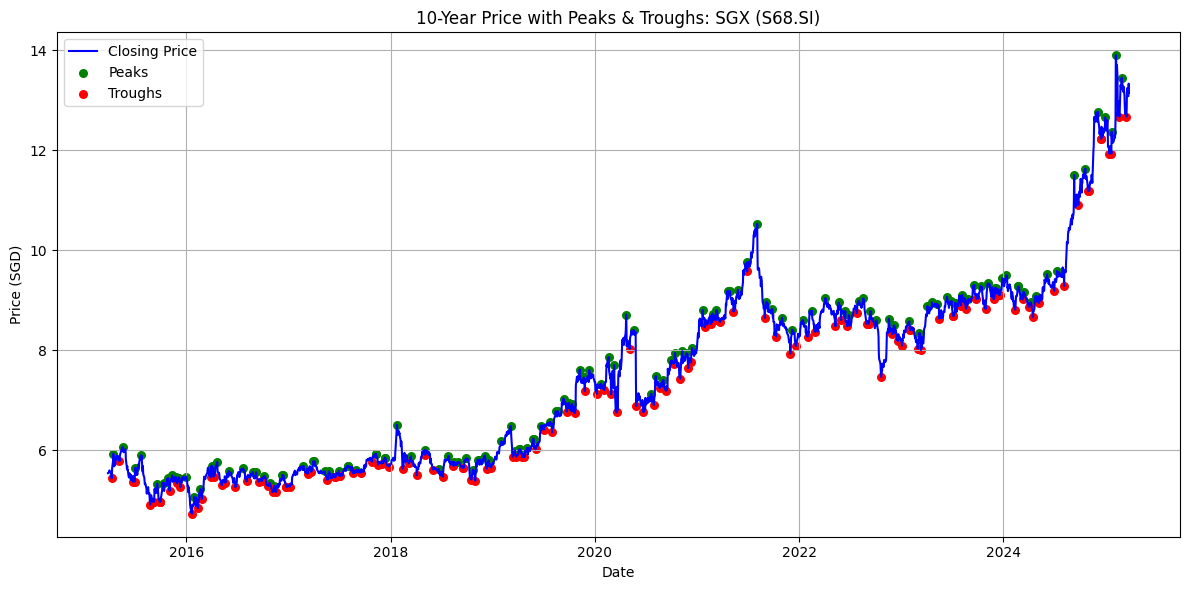

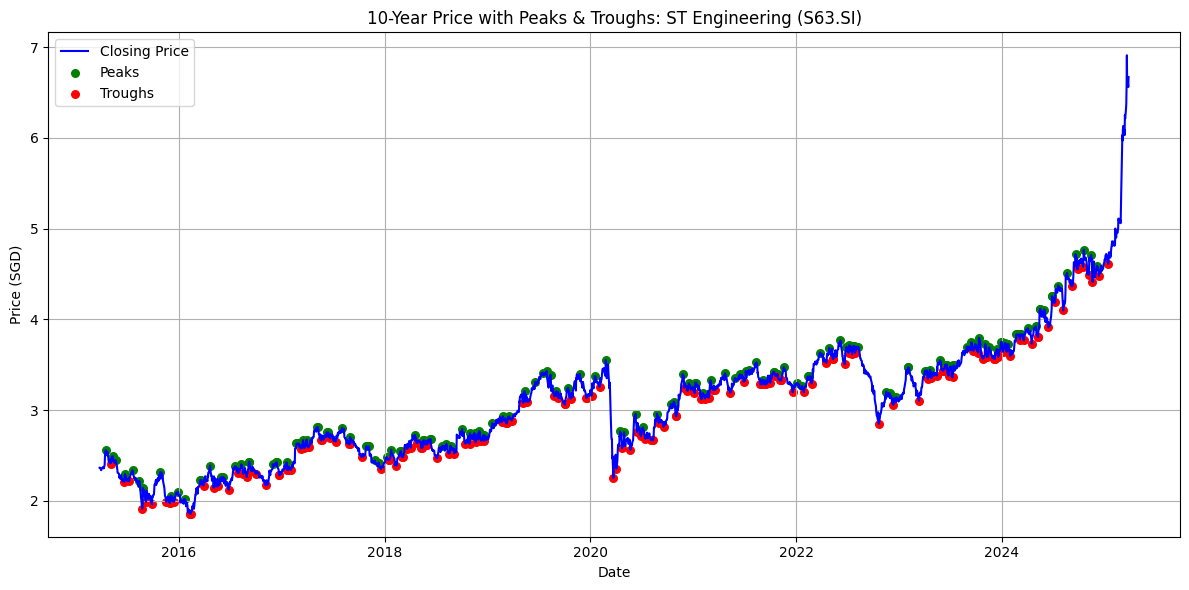

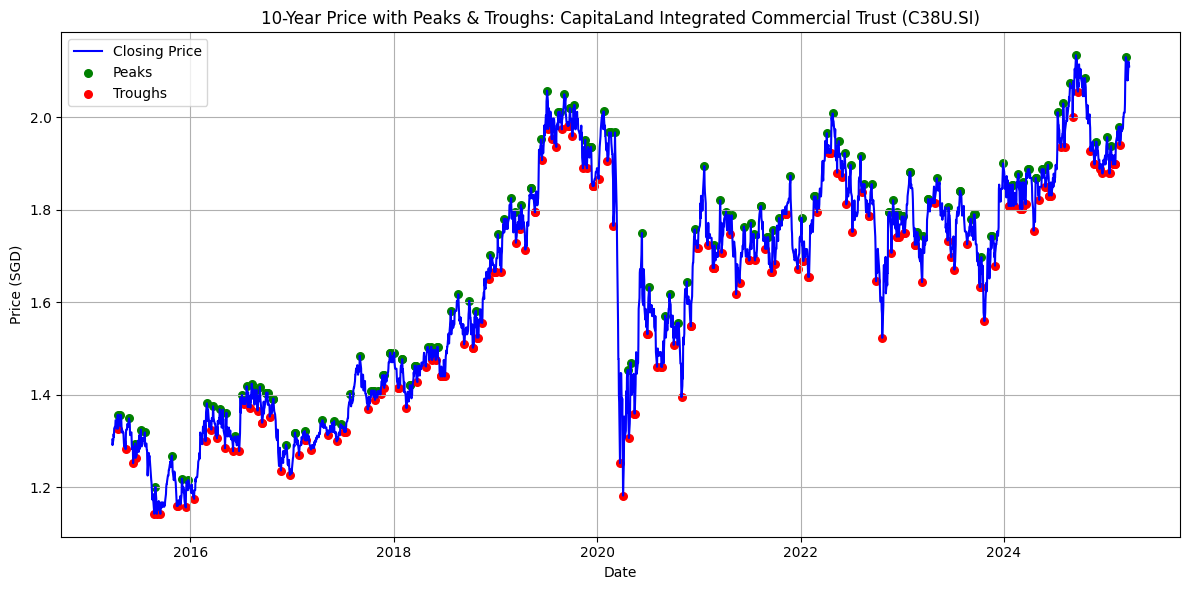

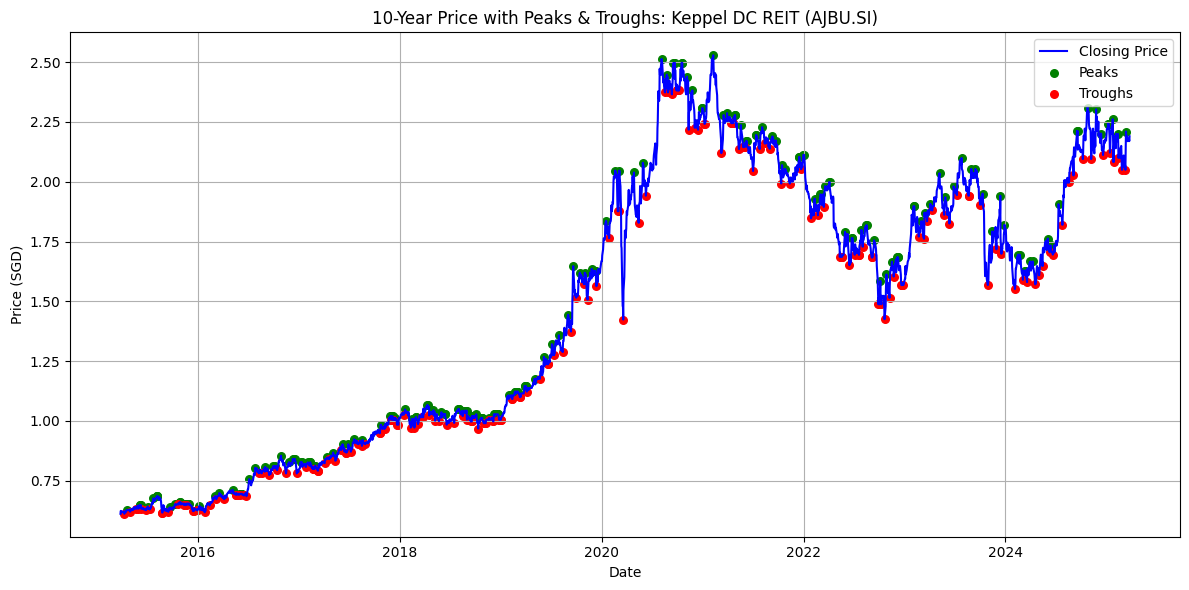

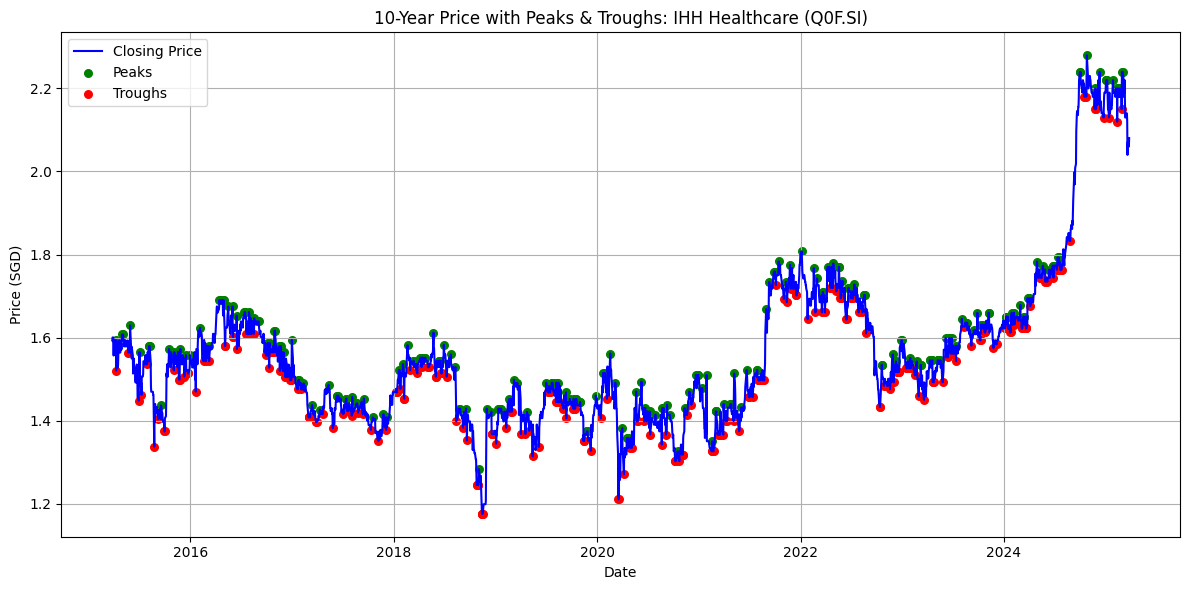

In [3]:
for symbol in df_filtered["Symbol"]:
    stock = yf.Ticker(symbol)
    hist = stock.history(period="10y")
    close = hist["Close"]

    # Detect peaks and troughs
    peaks = close[close == close.rolling(15, center=True).max()]
    troughs = close[close == close.rolling(15, center=True).min()]

    plt.figure(figsize=(12, 6))
    plt.plot(close, label="Closing Price", color="blue")
    plt.scatter(peaks.index, peaks.values, color='green', label='Peaks', s=30)
    plt.scatter(troughs.index, troughs.values, color='red', label='Troughs', s=30)
    plt.title(f"10-Year Price with Peaks & Troughs: {stock_symbols[symbol]} ({symbol})")
    plt.xlabel("Date")
    plt.ylabel("Price (SGD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


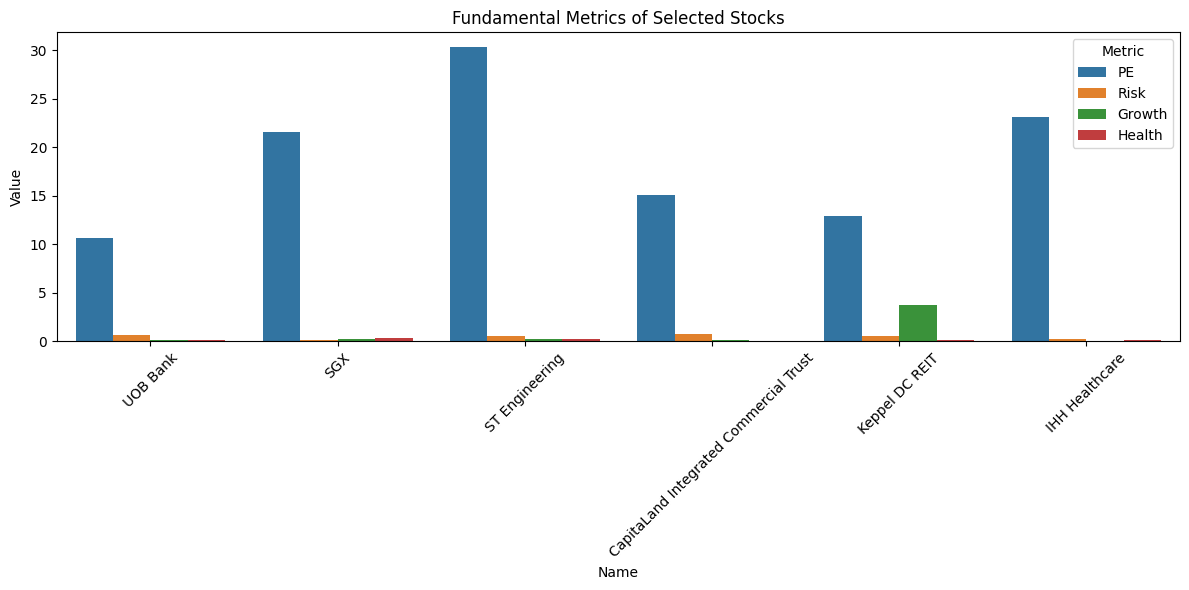

In [4]:
fundamental_cols = ["PE", "Risk", "Growth", "Health"]
df_melted = df_filtered.melt(id_vars=["Symbol", "Name"], value_vars=fundamental_cols, var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Name", y="Value", hue="Metric")
plt.title("Fundamental Metrics of Selected Stocks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_7968/3329444035.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x="Name", y="RL_Weight", palette="coolwarm")


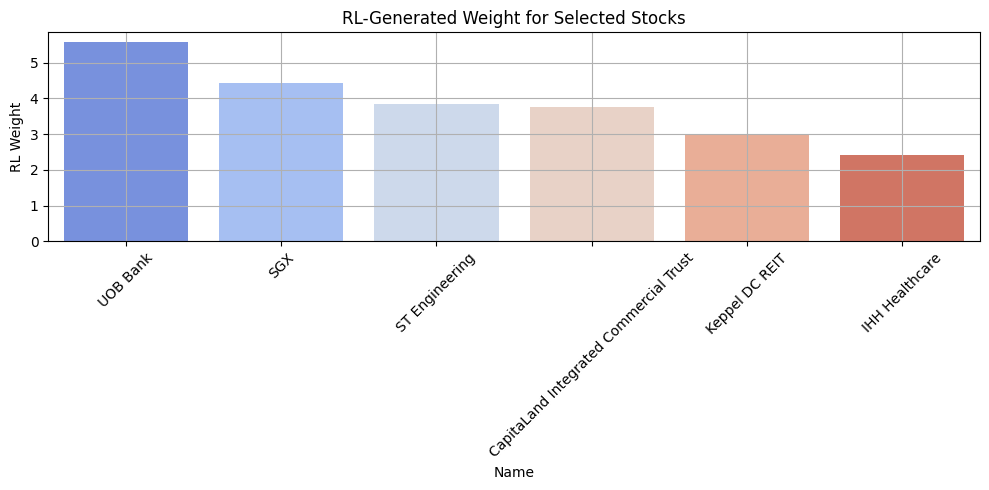

In [5]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_filtered, x="Name", y="RL_Weight", palette="coolwarm")
plt.title("RL-Generated Weight for Selected Stocks")
plt.ylabel("RL Weight")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


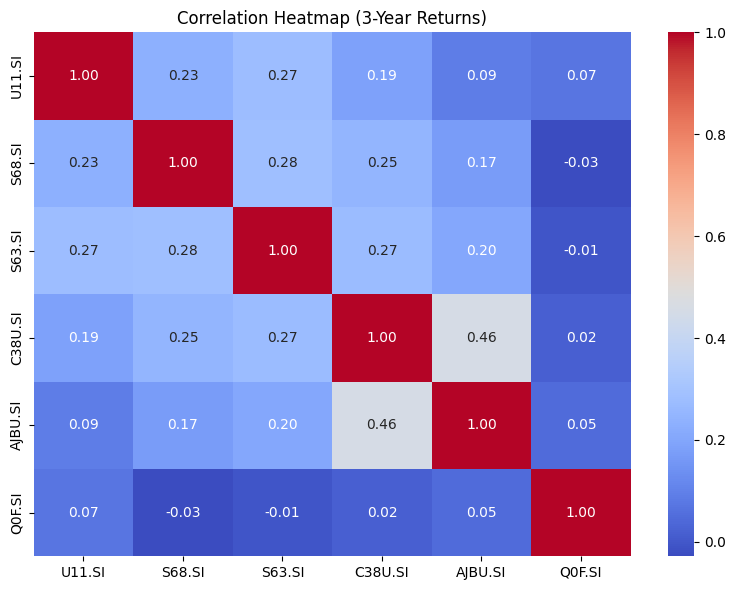

In [6]:
if not returns_df.empty:
    selected_returns = returns_df[df_filtered["Symbol"].tolist()]
    corr_matrix = selected_returns.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap (3-Year Returns)")
    plt.tight_layout()
    plt.show()


Epoch 1/50
1/1 [==============================] - 1s 582ms/step - loss: 5.7518e-04
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 5.7518e-04
Epoch 3/50
1/1 [==============================] - 0s 5ms/step - loss: 5.7518e-04
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 5.7518e-04
Epoch 5/50
1/1 [==============================] - 0s 6ms/step - loss: 5.7518e-04
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 5.7518e-04
Epoch 7/50
1/1 [==============================] - 0s 5ms/step - loss: 5.7518e-04
Epoch 8/50
1/1 [==============================] - 0s 7ms/step - loss: 5.7518e-04
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 5.7518e-04
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 5.7518e-04
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 5.7518e-04
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 5.7518e-04
Epoch 13/50
1/1 [======

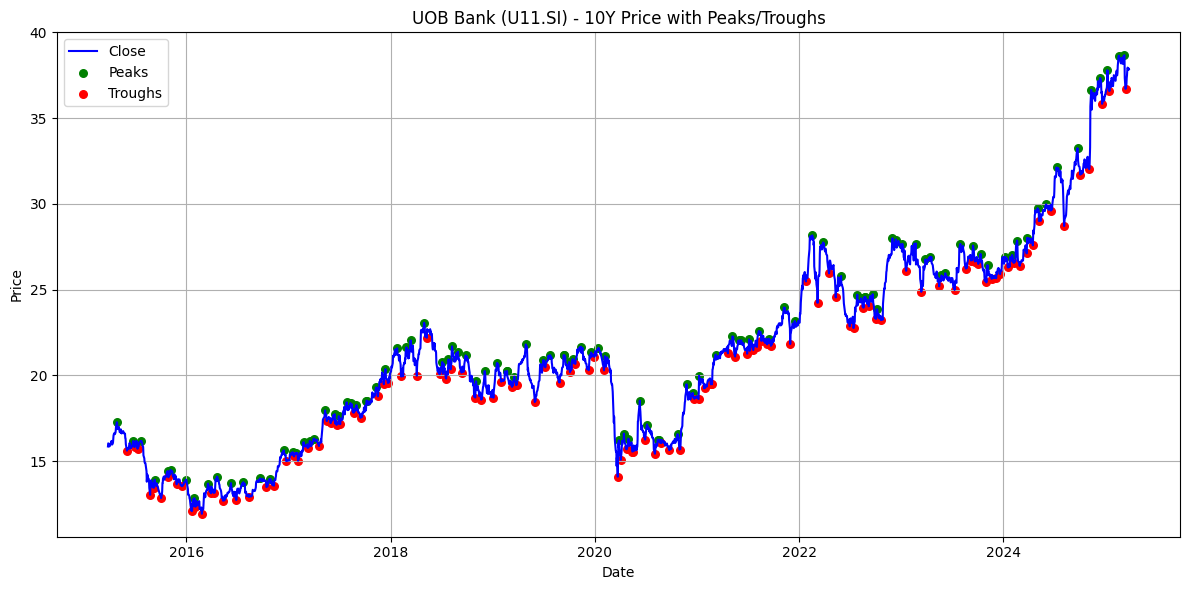

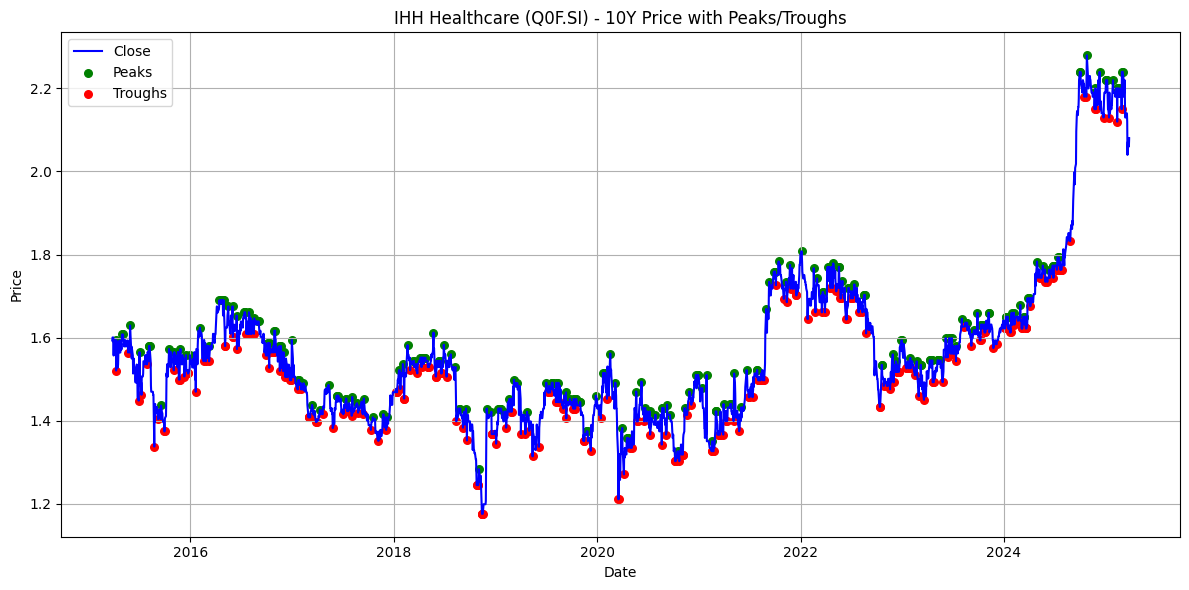

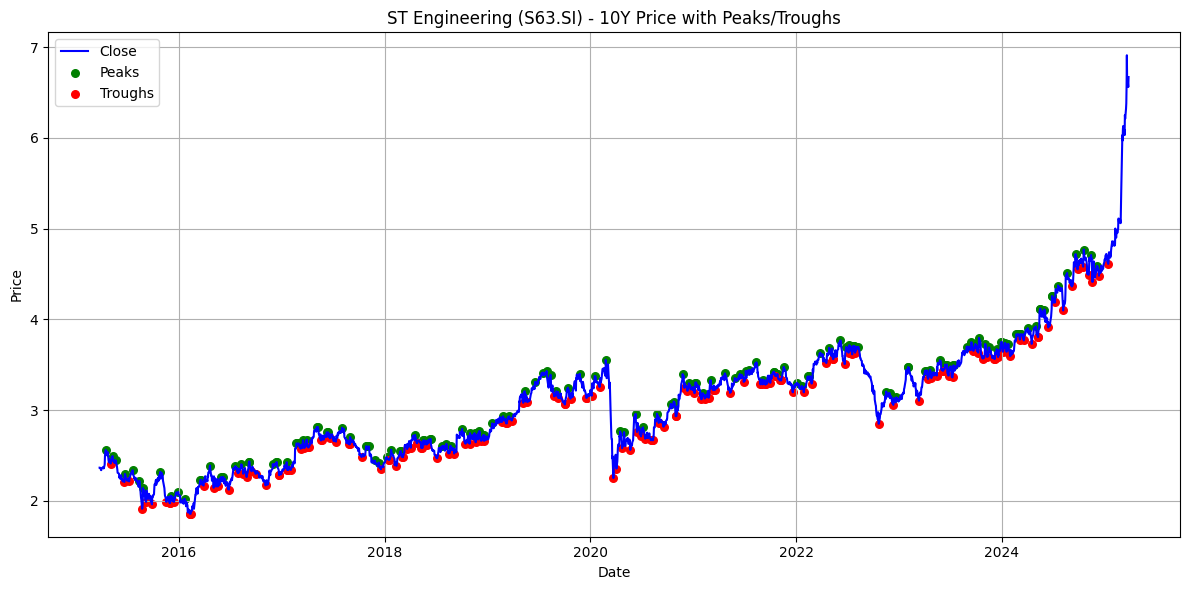

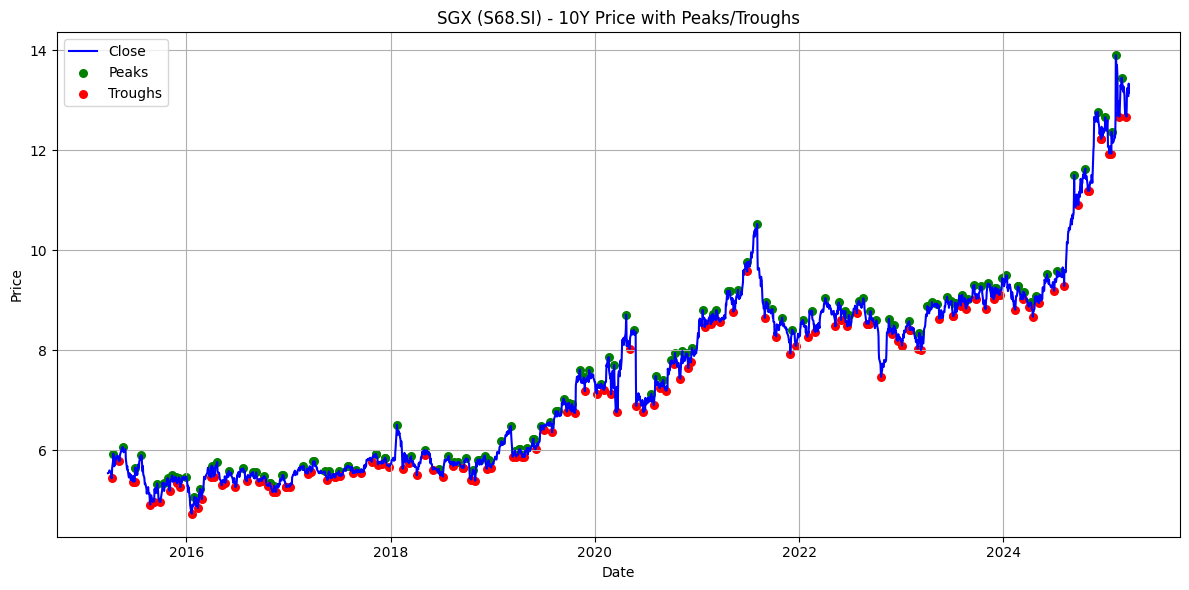

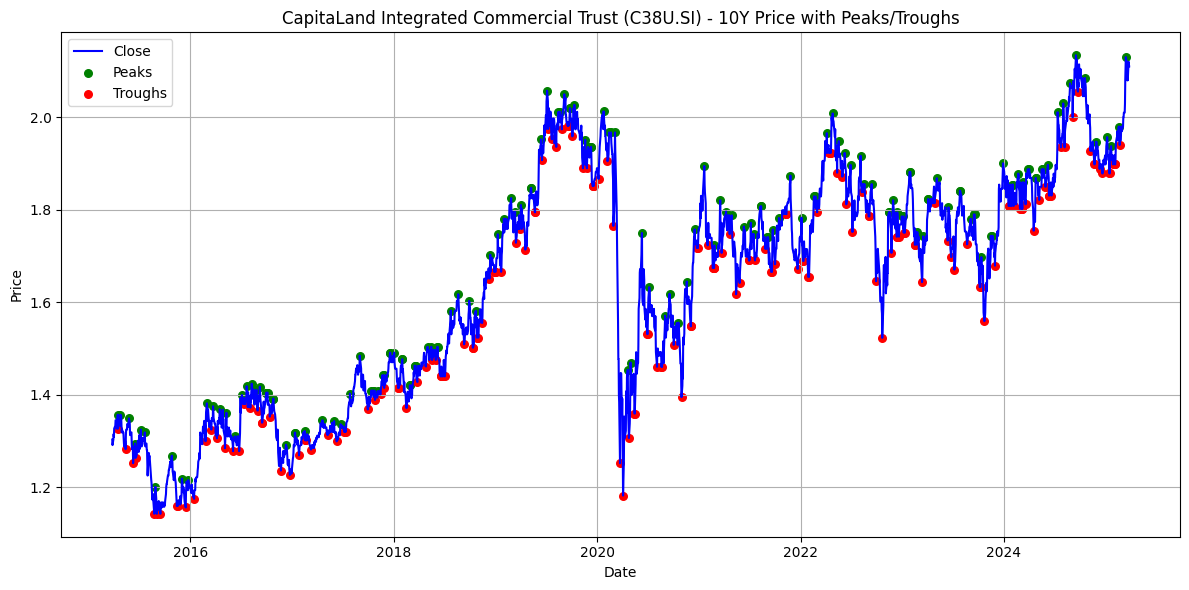

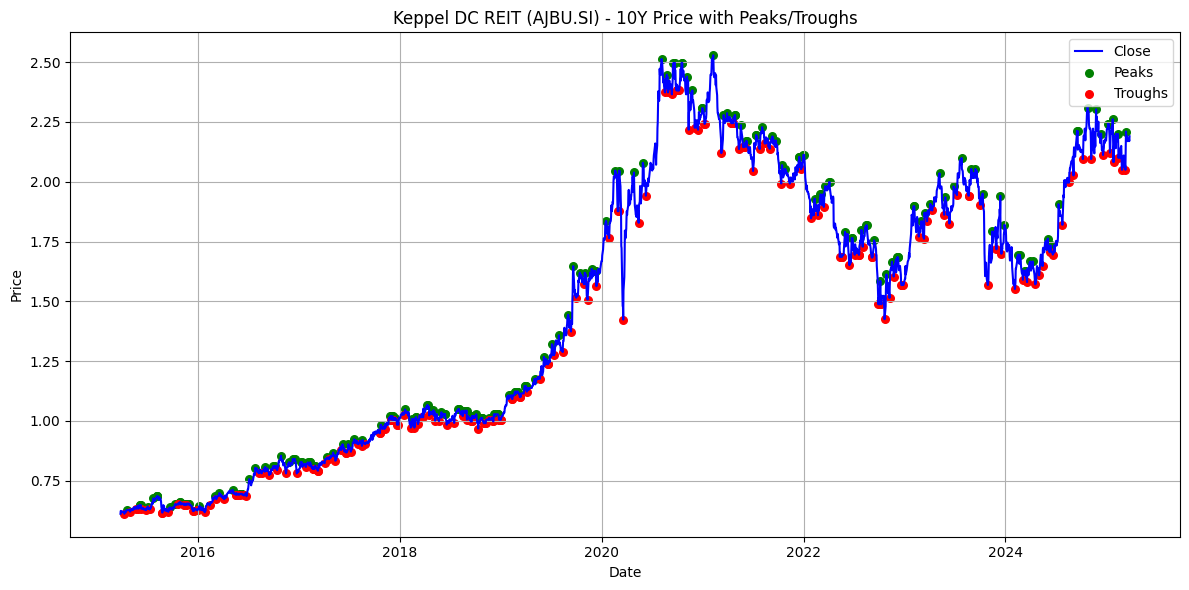

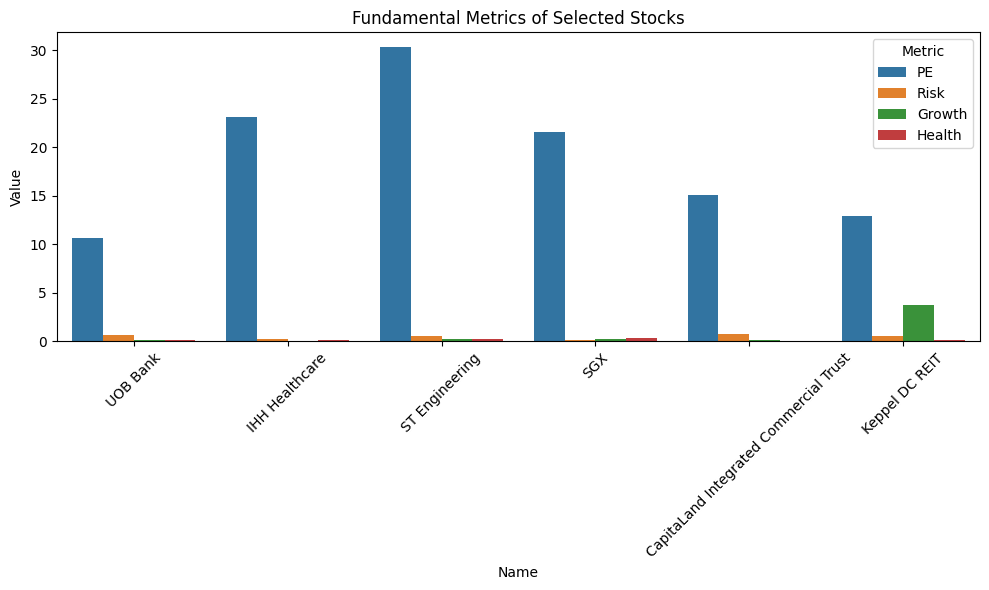

/tmp/ipykernel_7968/3186567843.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x="Name", y="RL_Weight", palette="coolwarm")


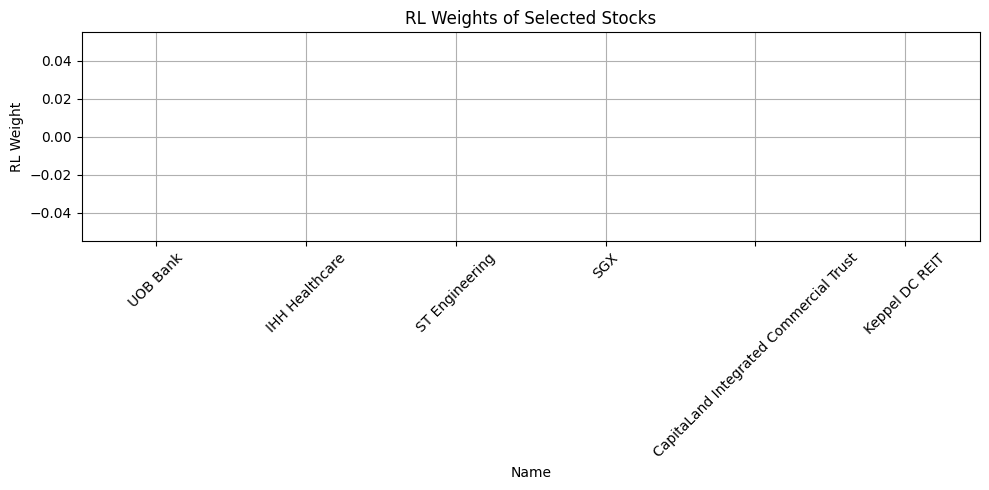

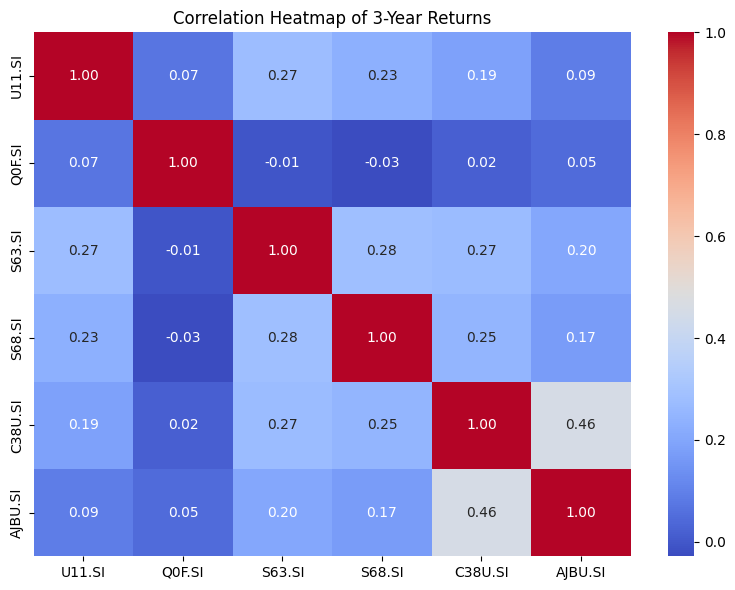

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# Define stock symbols with their names
stock_symbols = {
    "U11.SI": "UOB Bank",
    "Z74.SI": "SingTel",
    "F34.SI": "Wilmar International",
    "Q0F.SI": "IHH Healthcare",
    "S63.SI": "ST Engineering",
    "J36.SI": "Jardine Matheson",
    "S68.SI": "SGX",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "H78.SI": "Hongkong Land",
    "9CI.SI": "CapitaLand Investment",
    "BN4.SI": "Keppel Corp",
    "A17U.SI": "Ascendas REIT",
    "C07.SI": "Jardine C&C",
    "U96.SI": "Sembcorp Industries",
    "G13.SI": "Genting Singapore",
    "5E2.SI": "Seatrium",
    "N2IU.SI": "Mapletree Pan Asia Commercial Trust",
    "ME8U.SI": "Mapletree Industrial Trust",
    "S58.SI": "SATS",
    "AJBU.SI": "Keppel DC REIT"
}

# Fetch fundamentals with validation
def fetch_fundamentals(symbols):
    fundamentals = {}
    for symbol in symbols:
        try:
            stock = yf.Ticker(symbol)
            info = stock.info
            pe = info.get("trailingPE")
            risk = info.get("beta")
            growth = info.get("earningsGrowth")
            health = info.get("returnOnEquity")
            if None in (pe, risk, growth, health):
                continue
            fundamentals[symbol] = {
                "PE": pe,
                "Risk": risk,
                "Growth": growth,
                "Health": health
            }
        except Exception as e:
            print(f"Skipping {symbol}: {e}")
            continue
    return fundamentals

fundamentals = fetch_fundamentals(stock_symbols.keys())

# Calculate peak/trough speed
def get_peak_trough_speed(symbol):
    try:
        stock = yf.Ticker(symbol)
        hist = stock.history(period="10y")
        close = hist["Close"]
        peaks = close[close == close.rolling(15, center=True).max()].dropna()
        troughs = close[close == close.rolling(15, center=True).min()].dropna()
        if len(peaks) > 1 and len(troughs) > 1:
            peak_speed = np.mean(np.diff(peaks.index.to_numpy()).astype('timedelta64[D]').astype(int))
            trough_speed = np.mean(np.diff(troughs.index.to_numpy()).astype('timedelta64[D]').astype(int))
        else:
            peak_speed, trough_speed = np.inf, np.inf
        return peak_speed, trough_speed
    except Exception as e:
        print(f"Error processing {symbol} for peak/trough: {e}")
        return np.inf, np.inf

# Create training data
X_train = []
y_train = []
peak_trough_map = {}

for symbol in fundamentals:
    peak, trough = get_peak_trough_speed(symbol)
    if np.isinf(peak) or np.isinf(trough):
        continue
    score = 1 / (peak + trough)  # Higher score for faster movement
    X_train.append([peak, trough])
    y_train.append(score)
    peak_trough_map[symbol] = (peak, trough)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Normalize inputs
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Build and train RL model
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(2,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='relu')
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=50, verbose=1)

# Prepare dataset with RL weight
data_rows = []
for symbol in fundamentals:
    if symbol not in peak_trough_map:
        continue
    peak, trough = peak_trough_map[symbol]
    inputs_scaled = scaler.transform([[peak, trough]])
    weight = model.predict(inputs_scaled, verbose=0)[0][0]
    data_rows.append({
        "Symbol": symbol,
        "Name": stock_symbols.get(symbol, symbol),
        "PE": fundamentals[symbol]["PE"],
        "Risk": fundamentals[symbol]["Risk"],
        "Growth": fundamentals[symbol]["Growth"],
        "Health": fundamentals[symbol]["Health"],
        "PeakSpeed": peak,
        "TroughSpeed": trough,
        "RL_Weight": weight
    })

df = pd.DataFrame(data_rows)
if not df.empty and "Growth" in df.columns:
    df = df[df["Growth"].notna() & (df["Growth"] > 0)]
    df = df.sort_values(by="RL_Weight", ascending=False).head(6)

# Download 3-year historical returns for correlation filtering
def get_returns(symbol):
    try:
        stock = yf.Ticker(symbol)
        hist = stock.history(period="3y")
        returns = hist["Close"].pct_change().dropna()
        return returns
    except Exception as e:
        print(f"Error fetching returns for {symbol}: {e}")
        return None

return_data = {}
for symbol in df["Symbol"]:
    ret = get_returns(symbol)
    if ret is not None:
        return_data[symbol] = ret

returns_df = pd.DataFrame(return_data).dropna(axis=1)

# Select low-correlation stocks
selected_symbols = []
for symbol in df["Symbol"]:
    if symbol not in returns_df.columns:
        continue
    if not selected_symbols:
        selected_symbols.append(symbol)
    else:
        correlations = returns_df[selected_symbols].corrwith(returns_df[symbol])
        if all(abs(correlations) < 0.7):
            selected_symbols.append(symbol)
    if len(selected_symbols) == 6:
        break

df_filtered = df[df["Symbol"].isin(selected_symbols)]

print("\nSelected 6 Diverse & Low-Correlation Stocks:")
print(df_filtered[["Name", "Symbol", "PE", "Risk", "Growth", "Health", "PeakSpeed", "TroughSpeed", "RL_Weight"]])
df_filtered.to_csv("selected_top6_singapore_stocks.csv", index=False)
print("\nSaved to 'selected_top6_singapore_stocks.csv'")

# ================= PLOTTING SECTION =================

# 1. Plot historical price with peaks/troughs
for symbol in df_filtered["Symbol"]:
    stock = yf.Ticker(symbol)
    hist = stock.history(period="10y")
    close = hist["Close"]
    peaks = close[close == close.rolling(15, center=True).max()].dropna()
    troughs = close[close == close.rolling(15, center=True).min()].dropna()

    plt.figure(figsize=(12, 6))
    plt.plot(close, label="Close", color='blue')
    plt.scatter(peaks.index, peaks.values, color='green', label='Peaks', s=30)
    plt.scatter(troughs.index, troughs.values, color='red', label='Troughs', s=30)
    plt.title(f"{stock_symbols[symbol]} ({symbol}) - 10Y Price with Peaks/Troughs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2. Barplot of fundamentals
fundamental_cols = ["PE", "Risk", "Growth", "Health"]
df_melted = df_filtered.melt(id_vars=["Name"], value_vars=fundamental_cols, var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Name", y="Value", hue="Metric")
plt.title("Fundamental Metrics of Selected Stocks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Barplot of RL_Weight
plt.figure(figsize=(10, 5))
sns.barplot(data=df_filtered, x="Name", y="RL_Weight", palette="coolwarm")
plt.title("RL Weights of Selected Stocks")
plt.ylabel("RL Weight")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Correlation heatmap
if not returns_df.empty:
    selected_returns = returns_df[df_filtered["Symbol"].tolist()]
    corr_matrix = selected_returns.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of 3-Year Returns")
    plt.tight_layout()
    plt.show()


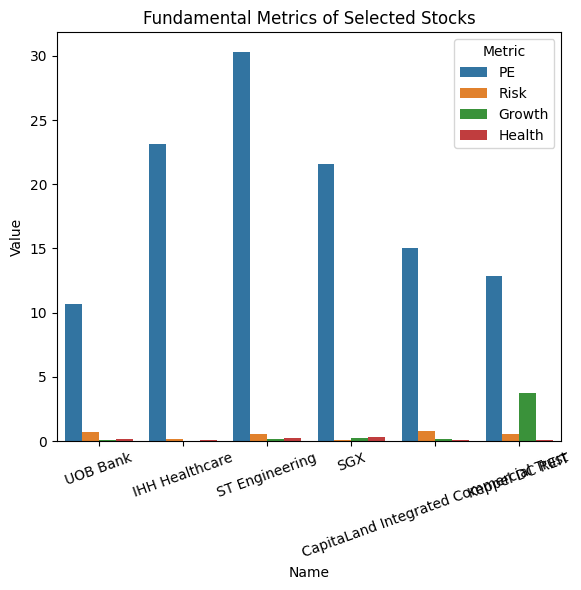

In [8]:
# 2. Barplot of fundamentals
fundamental_cols = ["PE","Risk", "Growth", "Health"]
df_melted = df_filtered.melt(id_vars=["Name"], value_vars=fundamental_cols, var_name="Metric", value_name="Value")

plt.figure(figsize=(6, 6))
sns.barplot(data=df_melted, x="Name", y="Value", hue="Metric")
plt.title("Fundamental Metrics of Selected Stocks")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

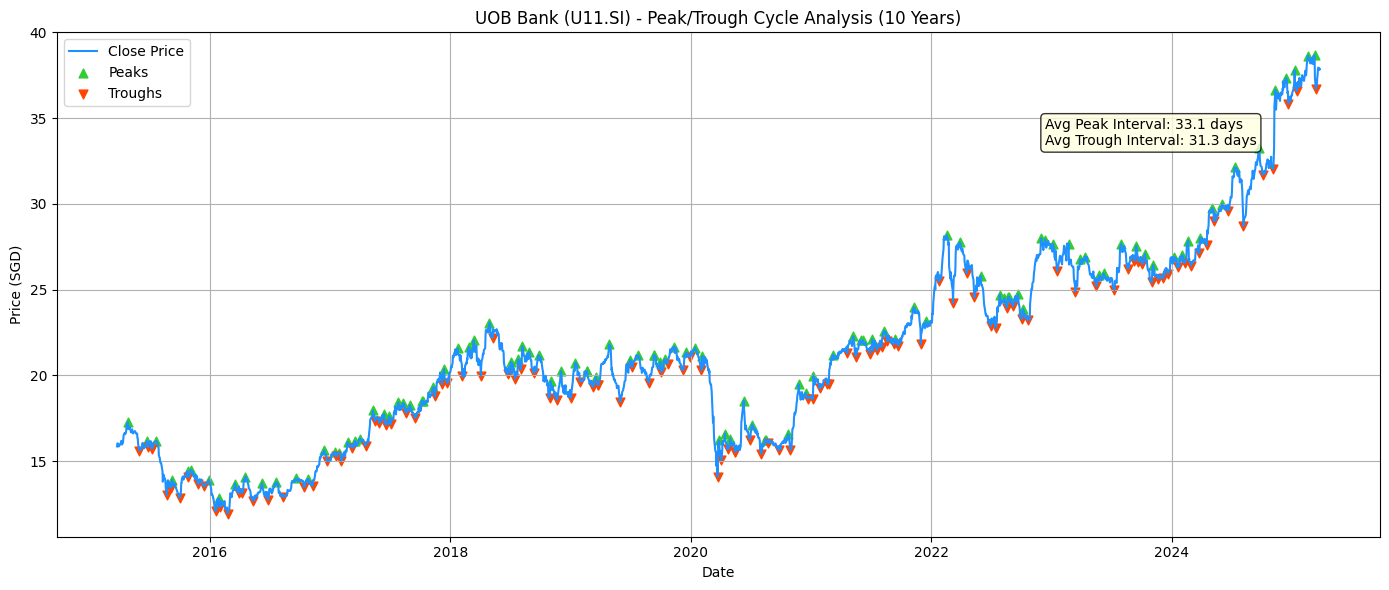

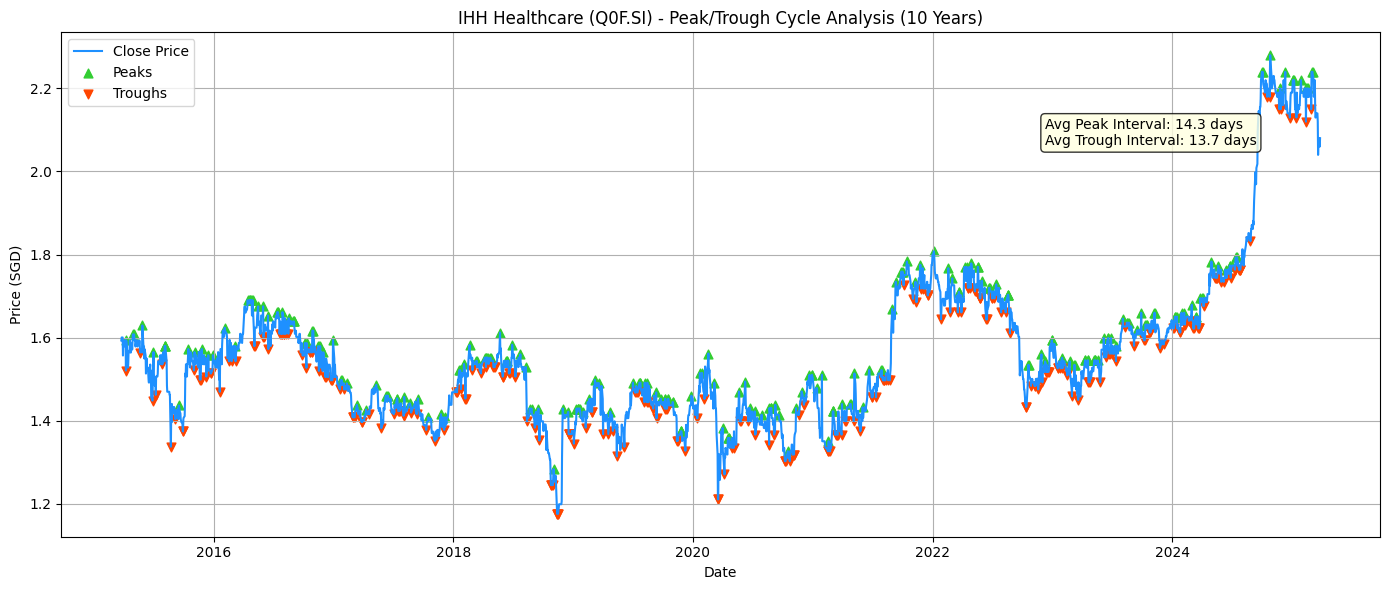

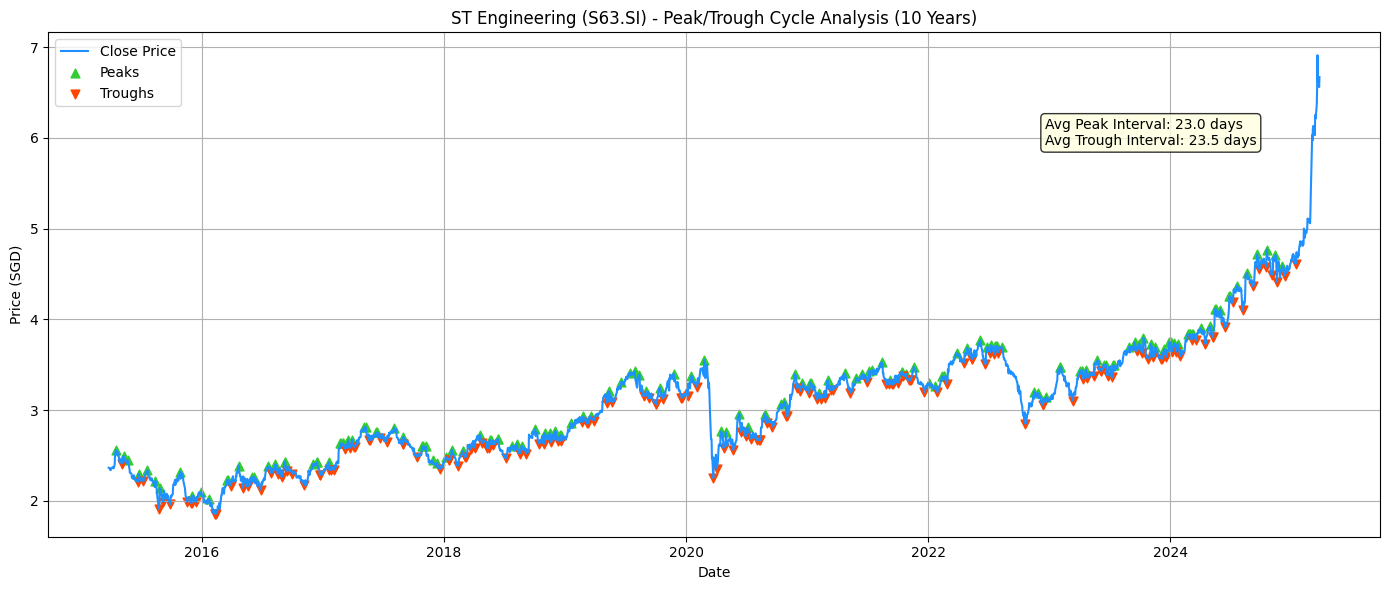

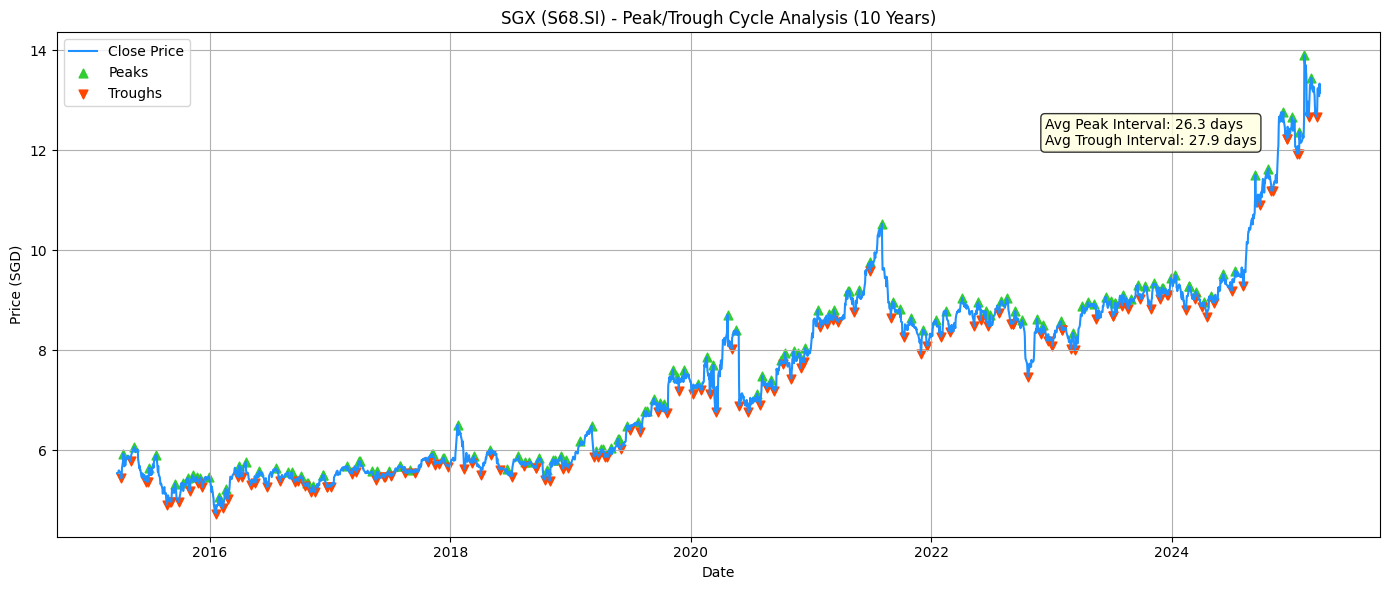

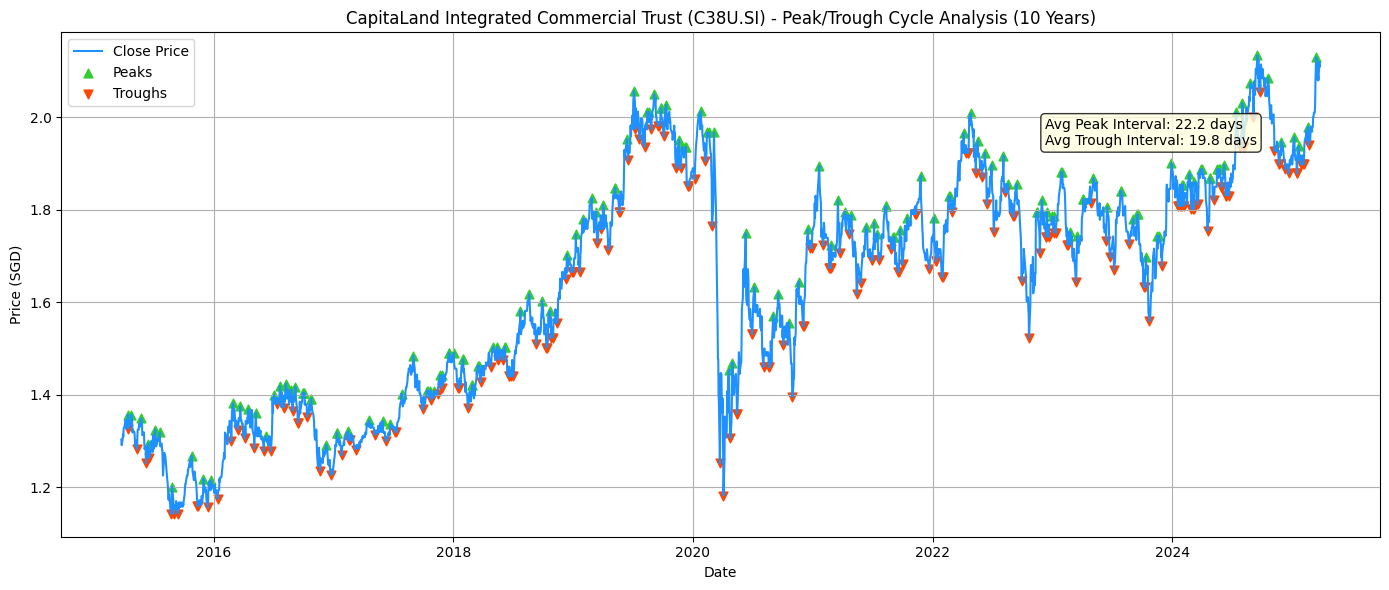

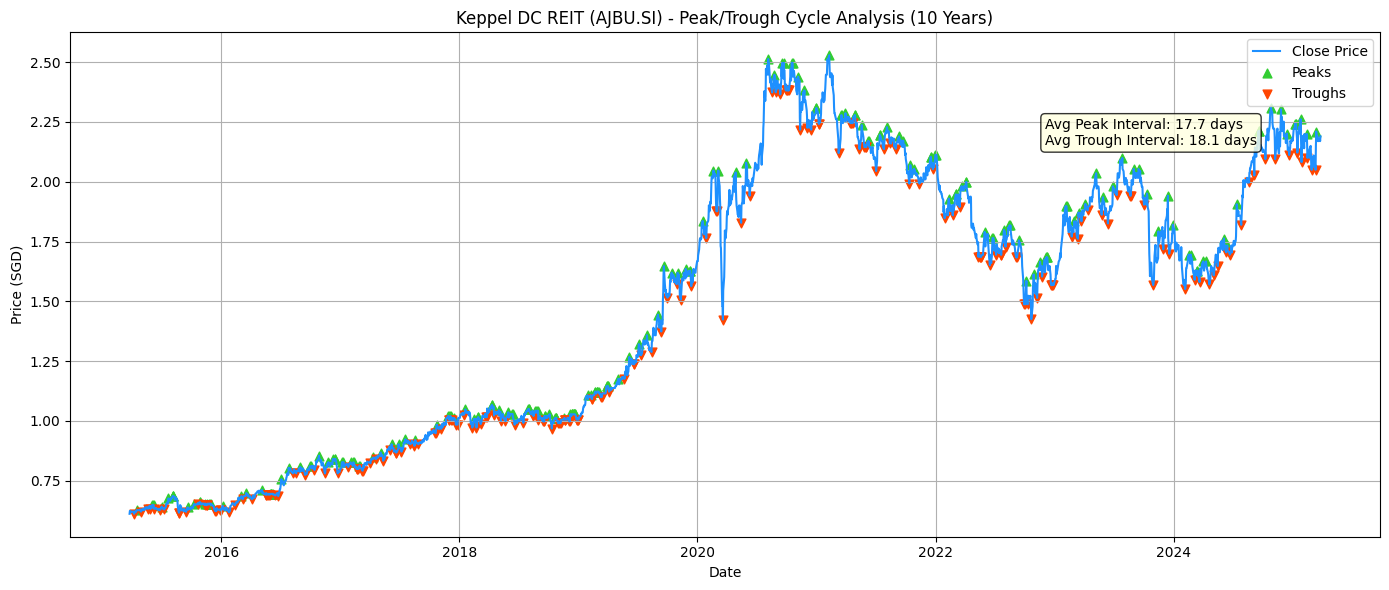

In [9]:
def plot_peak_trough_analysis(symbol, name, window=15):
    stock = yf.Ticker(symbol)
    hist = stock.history(period="10y")
    close = hist["Close"]

    # Identify peaks & troughs
    peaks = close[close == close.rolling(window, center=True).max()].dropna()
    troughs = close[close == close.rolling(window, center=True).min()].dropna()

    # Compute average cycle speed
    peak_intervals = np.diff(peaks.index.to_numpy()).astype('timedelta64[D]').astype(int)
    trough_intervals = np.diff(troughs.index.to_numpy()).astype('timedelta64[D]').astype(int)

    avg_peak_speed = np.mean(peak_intervals) if len(peak_intervals) > 0 else np.nan
    avg_trough_speed = np.mean(trough_intervals) if len(trough_intervals) > 0 else np.nan

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(close, label="Close Price", color='dodgerblue')
    plt.scatter(peaks.index, peaks.values, label='Peaks', color='limegreen', s=40, marker='^')
    plt.scatter(troughs.index, troughs.values, label='Troughs', color='orangered', s=40, marker='v')

    plt.title(f"{name} ({symbol}) - Peak/Trough Cycle Analysis (10 Years)")
    plt.xlabel("Date")
    plt.ylabel("Price (SGD)")
    plt.legend()

    # Annotate average cycle speed
    textstr = f"Avg Peak Interval: {avg_peak_speed:.1f} days\nAvg Trough Interval: {avg_trough_speed:.1f} days"
    plt.gcf().text(0.75, 0.75, textstr, fontsize=10, bbox=dict(boxstyle="round", facecolor='lightyellow', alpha=0.8))

    plt.grid(True)
    plt.tight_layout()
    plt.show()
for _, row in df_filtered.iterrows():
    plot_peak_trough_analysis(row["Symbol"], row["Name"])


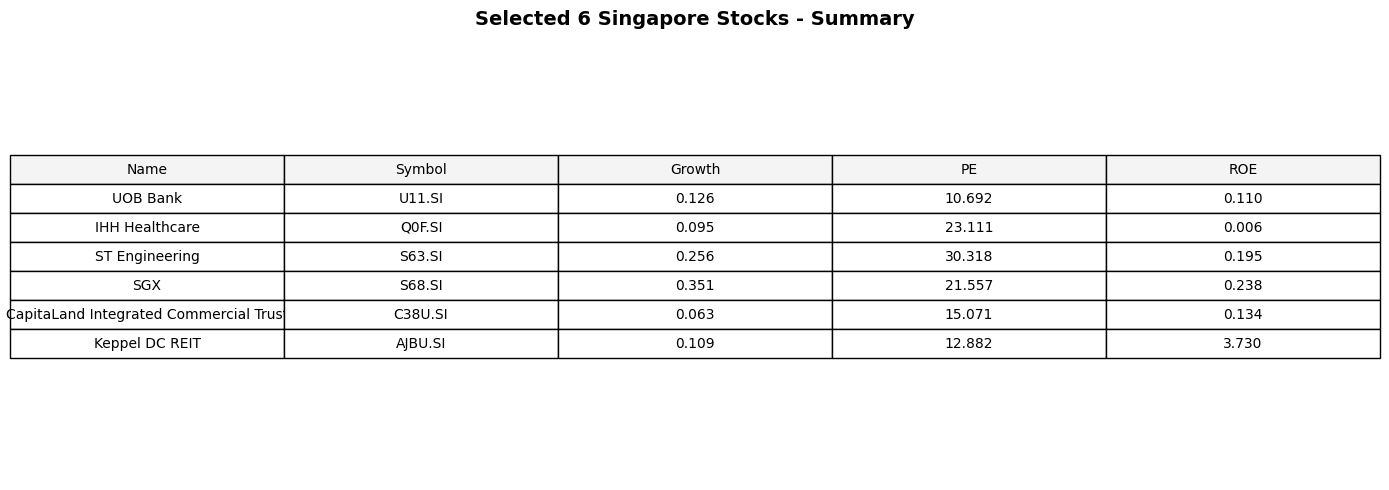

In [10]:
import matplotlib.pyplot as plt
def plot_selected_stock_table(df):
    # Select and rename columns
    display_df = df[[ "Name", "Symbol", "Health","PE", "Growth"]]
    display_df.columns = ["Name", "Symbol", "Growth", "PE","ROE"]

    # Separate columns
    str_cols = [ "Name", "Symbol"]
    num_cols = ["ROE", "PE","Growth"]

    # Convert numerical values to rounded strings for display
    formatted_data = display_df.copy()
    for col in num_cols:
        formatted_data[col] = formatted_data[col].apply(lambda x: f"{x:.3f}")

    # Plot as table
    fig, ax = plt.subplots(figsize=(14, 2 + 0.5 * len(display_df)))
    ax.axis("off")
    table = ax.table(
        cellText=formatted_data.values,
        colLabels=formatted_data.columns,
        cellLoc="center",
        loc="center",
        colColours=["#f4f4f4"] * len(display_df.columns)
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title("Selected 6 Singapore Stocks - Summary", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

plot_selected_stock_table(df_filtered)



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models



# # Define stock symbols with their names
# stock_symbols = {
#     "D05.SI": "DBS Group",
#     "O39.SI": "OCBC Bank",
#     "U11.SI": "UOB Bank",
#     "Z74.SI": "SingTel",
#     "F34.SI": "Wilmar International",
#     "Q0F.SI": "IHH Healthcare",
#     "C6L.SI": "Singapore Airlines",
#     "S63.SI": "ST Engineering",
#     "J36.SI": "Jardine Matheson",
#     "S68.SI": "SGX",
#     "C38U.SI": "CapitaLand Integrated Commercial Trust",
#     "Y92.SI": "Thai Beverage",
#     "H78.SI": "Hongkong Land",
#     "9CI.SI": "CapitaLand Investment",
#     "G07.SI": "Great Eastern",
#     "BN4.SI": "Keppel Corp",
#     "BS6.SI": "Yangzijiang Shipbuilding",
#     "A17U.SI": "Ascendas REIT",
#     "C07.SI": "Jardine C&C",
#     "U96.SI": "Sembcorp Industries",
#     "G13.SI": "Genting Singapore",
#     "5E2.SI": "Seatrium",
#     "N2IU.SI": "Mapletree Pan Asia Commercial Trust",
#     "M44U.SI": "Mapletree Logistics Trust",
#     "ME8U.SI": "Mapletree Industrial Trust",
#     "S58.SI": "SATS",
#     "AJBU.SI": "Keppel DC REIT"
# }

import yfinance as yf
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models

# Define stock symbols with their names
stock_symbols = {
    "U11.SI": "UOB Bank",
    "Z74.SI": "SingTel",
    "F34.SI": "Wilmar International",
    "Q0F.SI": "IHH Healthcare",
    "S63.SI": "ST Engineering",
    "J36.SI": "Jardine Matheson",
    "S68.SI": "SGX",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "H78.SI": "Hongkong Land",
    "9CI.SI": "CapitaLand Investment",
    "BN4.SI": "Keppel Corp",
    "A17U.SI": "Ascendas REIT",
    "C07.SI": "Jardine C&C",
    "U96.SI": "Sembcorp Industries",
    "G13.SI": "Genting Singapore",
    "5E2.SI": "Seatrium",
    "N2IU.SI": "Mapletree Pan Asia Commercial Trust",
    "ME8U.SI": "Mapletree Industrial Trust",
    "S58.SI": "SATS",
    "AJBU.SI": "Keppel DC REIT"
}

# --- Step 1: Fetch fundamentals ---
def fetch_fundamentals(symbols):
    fundamentals = {}
    for symbol in symbols:
        try:
            stock = yf.Ticker(symbol)
            info = stock.info
            pe = info.get("trailingPE")
            risk = info.get("beta")
            growth = info.get("earningsGrowth")
            health = info.get("returnOnEquity")
            market_cap = info.get("marketCap")
            if None in (pe, risk, growth, health, market_cap):
                continue
            fundamentals[symbol] = {
                "PE": pe,
                "Risk": risk,
                "Growth": growth,
                "Health": health,
                "MarketCap": market_cap
            }
        except Exception as e:
            print(f"Skipping {symbol}: {e}")
            continue
    return fundamentals

# --- Step 2: Peak/Trough Speed ---
def get_peak_trough_speed(symbol):
    try:
        stock = yf.Ticker(symbol)
        hist = stock.history(period="10y")
        close = hist["Close"]
        peaks = close[close == close.rolling(15, center=True).max()].dropna()
        troughs = close[close == close.rolling(15, center=True).min()].dropna()
        if len(peaks) > 1 and len(troughs) > 1:
            peak_speed = np.mean(np.diff(peaks.index.to_numpy()).astype('timedelta64[D]').astype(int))
            trough_speed = np.mean(np.diff(troughs.index.to_numpy()).astype('timedelta64[D]').astype(int))
        else:
            peak_speed, trough_speed = np.inf, np.inf
        return peak_speed, trough_speed
    except Exception as e:
        print(f"Error processing {symbol} for peak/trough: {e}")
        return np.inf, np.inf

# --- Step 3: Build RL-like model ---
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(2,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='relu')
])
model.compile(optimizer='adam', loss='mse')

# --- Step 4: Prepare dataset ---
fundamentals = fetch_fundamentals(stock_symbols.keys())
data_rows = []

for symbol in fundamentals:
    peak, trough = get_peak_trough_speed(symbol)
    if np.isinf(peak) or np.isinf(trough):
        continue
    inputs = np.array([[peak, trough]])
    weight = model.predict(inputs, verbose=0)[0][0]
    data_rows.append({
        "Symbol": symbol,
        "Name": stock_symbols.get(symbol, symbol),
        "PE": fundamentals[symbol]["PE"],
        "Risk": fundamentals[symbol]["Risk"],
        "Growth": fundamentals[symbol]["Growth"],
        "Health": fundamentals[symbol]["Health"],
        "MarketCap": fundamentals[symbol]["MarketCap"],
        "PeakSpeed": peak,
        "TroughSpeed": trough,
        "RL_Weight": weight
    })

# --- Step 5: Filter top 6 based on weight and positive growth ---
df = pd.DataFrame(data_rows)
if not df.empty:
    df = df[df["Growth"].notna() & (df["Growth"] > 0)]
    df = df.sort_values(by="RL_Weight", ascending=False).head(6)

# --- Step 6: Get 3-year returns for correlation filtering ---
def get_returns(symbol):
    try:
        stock = yf.Ticker(symbol)
        hist = stock.history(period="3y")
        returns = hist["Close"].pct_change().dropna()
        return returns
    except Exception as e:
        print(f"Error fetching returns for {symbol}: {e}")
        return None

return_data = {}
for symbol in df["Symbol"]:
    ret = get_returns(symbol)
    if ret is not None:
        return_data[symbol] = ret

returns_df = pd.DataFrame(return_data).dropna(axis=1)

# --- Step 7: Correlation filtering ---
selected_symbols = []
for symbol in df["Symbol"]:
    if symbol not in returns_df.columns:
        continue
    if not selected_symbols:
        selected_symbols.append(symbol)
    else:
        correlations = returns_df[selected_symbols].corrwith(returns_df[symbol])
        if all(abs(correlations) < 0.7):
            selected_symbols.append(symbol)
    if len(selected_symbols) == 6:
        break

# --- Final filtered dataframe ---
df_filtered = df[df["Symbol"].isin(selected_symbols)]

print("\n✅ Selected 6 Diverse & Low-Correlation Stocks:")
print(df_filtered)

# --- Save to CSV ---
df_filtered.to_csv("selected_top6_singapore_stocks.csv", index=False)
print("\n📁 Saved to 'selected_top6_singapore_stocks.csv'")


# Format Market Cap to billions
df_filtered["MarketCap (Billion SGD)"] = df_filtered["MarketCap"] / 1e9

# Select & rename columns for display
display_df = df_filtered[[
    "Name", "MarketCap (Billion SGD)", "PE", "Risk", "Growth", "Health"
]].rename(columns={
    "Name": "Company",
    "PE": "P/E Ratio",
    "Risk": "Beta (Risk)",
    "Growth": "Earnings Growth",
    "Health": "Return on Equity"
})

# Round numerical columns
display_df = display_df.round({
    "MarketCap (Billion SGD)": 2,
    "P/E Ratio": 2,
    "Beta (Risk)": 2,
    "Earnings Growth": 2,
    "Return on Equity": 2
})

# Style with pastel background
def pastel_style(df):
    return df.style.set_table_styles(
        [{'selector': 'th', 'props': [('background-color', '#f6f8fa'), ('font-weight', 'bold')]}]
    ).background_gradient(cmap="Pastel1", axis=0)

# Display styled table
styled_table = pastel_style(display_df)
styled_table


2025-03-28 14:56:02.813292: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 14:56:02.816470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-28 14:56:02.816480: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-28 14:56:03.739745: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-28 14:56:03.739831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (priya-Vivob


✅ Selected 6 Diverse & Low-Correlation Stocks:
     Symbol                                    Name         PE   Risk  Growth  \
0    U11.SI                                UOB Bank  10.757063  0.699   0.110   
2    Q0F.SI                          IHH Healthcare  23.222220  0.190   0.006   
3    S63.SI                          ST Engineering  30.818182  0.529   0.195   
4    S68.SI                                     SGX  21.852459  0.117   0.238   
5   C38U.SI  CapitaLand Integrated Commercial Trust  14.999999  0.750   0.134   
10  AJBU.SI                          Keppel DC REIT  12.705883  0.588   3.730   

     Health    MarketCap  PeakSpeed  TroughSpeed  RL_Weight  
0   0.12567  63651864576  33.073394    31.342105        0.0  
2   0.09543  18529583104  14.345238    13.733840        0.0  
3   0.25572  21169195008  23.000000    23.456954        0.0  
4   0.35105  14270031872  26.529412    27.503817        0.0  
5   0.06253  15359630336  22.214724    19.769231        0.0  
10  0.10863 

,Company,MarketCap (Billion SGD),P/E Ratio,Beta (Risk),Earnings Growth,Return on Equity
0,UOB Bank,63.650000,10.760000,0.700000,0.110000,0.130000
2,IHH Healthcare,18.530000,23.220000,0.190000,0.010000,0.100000
3,ST Engineering,21.170000,30.820000,0.530000,0.200000,0.260000
4,SGX,14.270000,21.850000,0.120000,0.240000,0.350000
5,CapitaLand Integrated Commercial Trust,15.360000,15.000000,0.750000,0.130000,0.060000
10,Keppel DC REIT,4.870000,12.710000,0.590000,3.730000,0.110000
